In [1]:
import opensees
from opensees import section, layer, patch, element, uniaxial
from opensees.render import mpl as render

In [2]:
from math import cos,sin,sqrt,pi
import opensees
import opensees.tcl
from opensees.units.english import *
# --------------------------------------------------------------------------------------------------
# build a section

# MATERIAL parameters -------------------------------------------------------------------
IDconcU = 1                # material ID tag -- unconfined cover concrete
IDreinf = 2                # material ID tag -- reinforcement
# nominal concrete compressive strength
fc = -4.0*ksi              # Concrete Compressive Strength ksi
Ec = 57*ksi*sqrt(-fc/psi)  # Concrete Elastic Modulus
# unconfined concrete
fc1U = fc                  # UNCONFINED concrete (todeschini parabolic model) maximum stress
eps1U = -0.003             # strain at maximum strength of unconfined concrete
fc2U = 0.2*fc1U            # ultimate stress
eps2U = -0.01              # strain at ultimate stress
_lambda = 0.1              # ratio between unloading slope at eps2 and initial slope Ec
# tensile-strength properties
ftU = -0.14*fc1U           # tensile strength +tension
Ets = ftU/0.002            # tension softening stiffness
# -----------
Fy = 66.8*ksi              # STEEL yield stress
Es = 29000.*ksi            # modulus of steel
Bs = 0.005                 # strain-hardening ratio 
R0 = 18                    # control the transition from elastic to plastic branches
cR1 = 0.925                # control the transition from elastic to plastic branches
cR2 = 0.15                 # control the transition from elastic to plastic branches

In [3]:
concU = uniaxial.Concrete02(IDconcU, fc1U, eps1U, fc2U, eps2U, _lambda, ftU, Ets)      # build 'cover, concrete (unconfined)
reinf = uniaxial.Steel02(IDreinf, Fy, Es, Bs, R0, cR1, cR2)                            # build 'reinforcement' material

## Section Geometry
```
                      y
                      ^
                      |     
           ---------------------     --   --
           |   o     o     o   |     |    -- cover
           |                   |     |
           |                   |     |
    z <--- |         +         |     H
           |                   |     |
           |                   |     |
           |   o     o     o   |     |    -- cover
           ---------------------     --   --
           |-------- B ---------|
```

In [4]:
HSec = 5.*ft            # Column Depth
BSec = 3.*ft            # Column Width
coverSec = 5.*inch      # Column cover to reinforcing steel NA.
numBarsSec = 4          # number of longitudinal-reinforcement bars in steel layer. (symmetric top & bot)
barAreaSec = 1*in2      # area of longitudinal-reinforcement bars
SecTag = 1              # tag = for symmetric section

# FIBER SECTION properties -------------------------------------------------------------
# RC section: 
coverY = HSec/2.0        # Distance from section z-axis to edge of cover concrete -- outer edge of cover concrete
coverZ = BSec/2.0        # Distance from section y-axis to edge of cover concrete -- outer edge of cover concrete
coreY = coverY-coverSec  # Distance from section z-axis to edge of core concrete --  edge of the core concrete/inner edge of cover concrete
coreZ = coverZ-coverSec  # Distance from section y-axis to edge of core concrete --  edge of the core concrete/inner edge of cover concrete
nfY = 16                 # number of fibers for concrete in y-direction
nfZ = 4                  # number of fibers for concrete in z-direction

In [5]:
# Define the fiber section
sect = section.FiberSection(SecTag,  1e6, [       
   patch.quad(concU, [nfZ, nfY],    # Define the, concrete 'patch'
       [[-coverY, coverZ],[-coverY, -coverZ],
        [coverY, -coverZ],[coverY, coverZ]]),
   layer.line(reinf, numBarsSec, barAreaSec, [[ coreY, coreZ],[ coreY, -coreZ]]),  # top layer reinforcement
   layer.line(reinf, numBarsSec, barAreaSec, [[-coreY, coreZ],[-coreY, -coreZ]]),  # bottom layer reinfocement
])

<AxesSubplot:>

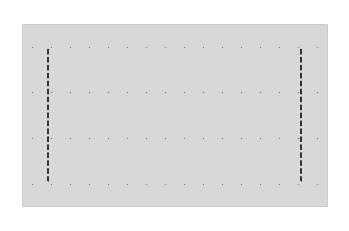

In [6]:
render.section(sect)

In [7]:
with sect as s:
    import opensees.libOpenSeesRT
    s.setTrialSectionDeformation(opensees.libOpenSeesRT.Vector([0.001, 0.0001]))
    print(s.getStressResultant())
    
    s.setTrialSectionDeformation([0.001, 0.0002])
    print(s.getStressResultant())
    
    print(s.getStressResultant([0.001, 0.0002], False))

ptr	 <capsule object NULL at 0x7f7ee1ed3240>
itemsize	 8
format	 d
ndim	 1
shape	 [2]
strides	 [8]
array	 [0.001  0.0001]
[-1179810.28319556 44656395.7301852 ]
[-2618400.28416247 65680643.59768373]
[-2618400.28416247 65680643.59768373]


In [8]:
print(opensees.tcl.dumps(sect))

uniaxialMaterial Concrete02  1  -4000.0  -0.003  -800.0  -0.01  0.1  560.0  280000.0 
uniaxialMaterial Steel02  2  66800.0  29000000.0  0.005  18  0.925  0.15 
section FiberSection  1 -GJ 1000000.0  { 
	patch quad  1   4  16    -30.000000000000004  18.000000000000004   -30.000000000000004  -18.000000000000004   30.000000000000004  -18.000000000000004   30.000000000000004  18.000000000000004 
	layer line  2  4  1.0    25.000000000000004  13.000000000000004   25.000000000000004  -13.000000000000004 
	layer line  2  4  1.0    -25.000000000000004  13.000000000000004   -25.000000000000004  -13.000000000000004 
} 



In [9]:
sect.fibers[-1].fibers

AttributeError: 'Fiber' object has no attribute 'fibers'